In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('complete_data_dev_final_1.csv', sep=';')
to_predict = pd.read_csv('complete_data_comp_final_1.csv', sep=';')

In [3]:
to_predict.columns

Index(['Unnamed: 0', 'frequency', 'date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan_id', 'loan date',
       'loan amount', 'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age at loan (Years)', 'unemploymant rate',
       'no. of commited crimes per capita'],
      dtype='object')

In [4]:
data.columns

Index(['Unnamed: 0', 'frequency', 'date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan_id', 'loan date',
       'loan amount', 'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age at loan (Years)', 'unemploymant rate',
       'no. of commited crimes per capita'],
      dtype='object')

In [5]:
data.dtypes

Unnamed: 0                                             int64
frequency                                             object
date                                                  object
# trans                                              float64
oper #1                                              float64
oper #2                                              float64
oper #3                                              float64
oper #4                                              float64
oper #5                                              float64
type #1                                              float64
type #2                                              float64
type #3                                              float64
avg trans amount                                     float64
avg trans balance                                    float64
loan_id                                                int64
loan date                                             object
loan amount             

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 36 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         328 non-null    int64  
 1   frequency                                          328 non-null    object 
 2   date                                               328 non-null    object 
 3   # trans                                            328 non-null    float64
 4   oper #1                                            328 non-null    float64
 5   oper #2                                            328 non-null    float64
 6   oper #3                                            328 non-null    float64
 7   oper #4                                            328 non-null    float64
 8   oper #5                                            328 non-null    float64
 9   type #1   

# Preprocessing

In [7]:
data['loan status'].unique()

array([ 1, -1], dtype=int64)

In [8]:
{column: len(data[column].unique()) for column in data.columns}

{'Unnamed: 0': 328,
 'frequency': 3,
 'date': 286,
 '# trans': 146,
 'oper #1': 42,
 'oper #2': 6,
 'oper #3': 21,
 'oper #4': 46,
 'oper #5': 86,
 'type #1': 101,
 'type #2': 14,
 'type #3': 65,
 'avg trans amount': 328,
 'avg trans balance': 328,
 'loan_id': 328,
 'loan date': 283,
 'loan amount': 316,
 'loan duration (mths)': 5,
 'loan payments': 300,
 'loan status': 2,
 'no. of inhabitants': 73,
 'no. of municipalities with inhabitants < 499 ': 52,
 'no. of municipalities with inhabitants 500-1999': 34,
 'no. of municipalities with inhabitants 2000-9999 ': 17,
 'no. of municipalities with inhabitants >10000 ': 6,
 'no. of cities ': 11,
 'ratio of urban inhabitants ': 66,
 'average salary ': 73,
 'no. of enterpreneurs per 1000 inhabitants ': 44,
 'card type': 4,
 'birthdate': 318,
 'sex': 2,
 'has disponent': 2,
 'age at loan (Years)': 319,
 'unemploymant rate': 72,
 'no. of commited crimes per capita': 73}

In [9]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x : 1 if x == positive_value else 0)
    return df
    
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x : ordering.index(x))
    return df

def special_binary_encode(df, column, negative_value):
    df = df.copy()
    df['card_owner'] = df[column].apply(lambda x : 0 if x == negative_value else 1)
    df = df.drop(column, axis=1)
    return df

In [10]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop index column
    df = df.drop('Unnamed: 0', axis=1)
    
    # Create datetime columns
    for column in ['date', 'loan date', 'birthdate']:
        df[column] = pd.to_datetime(df[column])
    
    df['account_year'] = df['date'].apply(lambda x : x.year)
    df['account_month'] = df['date'].apply(lambda x : x.month)
    df['account_day'] = df['date'].apply(lambda x : x.day)
    
    df['loan_year'] = df['loan date'].apply(lambda x : x.year)
    df['loan_month'] = df['loan date'].apply(lambda x : x.month)
    df['loan_day'] = df['loan date'].apply(lambda x : x.day)
    
    df['birth_year'] = df['birthdate'].apply(lambda x : x.year)
    df['birth_month'] = df['birthdate'].apply(lambda x : x.month)
    df['birth_day'] = df['birthdate'].apply(lambda x : x.day)
    
    df = df.drop(['date', 'loan_id', 'loan date', 'birthdate'], axis=1)
    
    
    # Binary encode the Gender column
    df = binary_encode(df, 'sex', positive_value='M')
    
    # Ordinal encode the frequency column
    freq_ordering = [
        'monthly issuance',
        'weekly issuance',
        'issuance after transaction'
    ]
    df = ordinal_encode(df, 'frequency', ordering=freq_ordering)
    
    # Binary encode the card column (has or not card)
    freq_ordering = [
        'monthly issuance',
        'weekly issuance',
        'issuance after transaction'
    ]
    
    df = special_binary_encode(df, 'card type', negative_value='None')
    
    # Encode the label (loan status) column
    label_mapping = {-1: 1, 1: 0}
    df['loan status'] = df['loan status'].replace(label_mapping)
    
    # Split df into X and y
    y = df['loan status'].copy()
    X = df.drop('loan status', axis=1).copy()
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [11]:
X, y = preprocess_inputs(data)

In [12]:
X

,frequency,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,...,account_year,account_month,account_day,loan_year,loan_month,loan_day,birth_year,birth_month,birth_day,card_owner
0,-0.480560,-0.484123,-1.141262,-0.119264,1.233962,-0.690169,-0.175290,-0.467362,0.187912,-0.546253,...,-0.940336,-1.488531,-0.284807,-2.027475,1.153455,0.723734,0.900846,-0.755336,1.411913,-0.18628
1,1.331207,-0.417122,-0.962069,-0.119264,1.070034,-0.242344,-0.353018,-0.332479,-0.441018,-0.481336,...,-0.940336,-0.305640,0.665998,-0.975241,-0.893170,-0.907402,0.342136,-1.343816,-1.633362,-0.18628
2,1.331207,-0.327787,-1.051665,-0.119264,1.070034,-0.690169,0.135734,-0.298758,0.816842,-0.546253,...,-0.940336,0.285805,-0.997910,-0.975241,-0.308420,-1.124887,0.661399,0.127384,-0.618271,-0.18628
3,-0.480560,0.945232,1.098649,-0.119264,-0.569252,-0.690169,1.601990,0.948911,-0.441018,1.011756,...,0.011609,-0.305640,1.260251,1.129226,-0.893170,0.288764,1.699002,0.715865,0.171245,-0.18628
4,1.331207,1.235569,2.352999,-0.119264,-0.569252,0.205481,1.202102,1.016352,-0.126553,1.660927,...,0.011609,-0.009918,-1.235611,0.076993,0.861080,-1.451114,-0.296388,1.304345,0.284033,-0.18628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,1.331207,-1.444471,-0.872472,-0.119264,-0.569252,-0.690169,-1.419386,-1.310381,-0.755483,-1.520009,...,0.963554,1.764419,1.379102,1.129226,-0.600795,-0.146205,-1.892701,0.127384,0.622397,-0.18628
324,-0.480560,0.163553,1.188245,-0.119264,-0.569252,-0.242344,0.180166,-0.028992,0.502377,0.427503,...,0.963554,1.764419,-0.047105,1.129226,1.153455,-0.689917,0.342136,1.010105,-0.392695,-0.18628
325,1.331207,-1.020131,-0.514087,-0.119264,-0.569252,-0.690169,-0.886202,-0.973173,-0.126553,-1.065590,...,1.915499,-1.488531,1.497952,1.129226,0.276330,1.376188,-1.094545,0.421625,-0.956634,-0.18628
326,1.331207,-0.975464,-0.962069,-0.119264,0.578248,-0.466256,-1.019498,-0.939452,-0.441018,-0.935756,...,1.915499,-1.192809,-1.711014,1.129226,0.276330,0.506249,1.459555,0.421625,-1.407786,-0.18628


In [13]:
{column: len(X[column].unique()) for column in X.columns}

{'frequency': 3,
 '# trans': 146,
 'oper #1': 42,
 'oper #2': 6,
 'oper #3': 21,
 'oper #4': 46,
 'oper #5': 86,
 'type #1': 101,
 'type #2': 14,
 'type #3': 65,
 'avg trans amount': 328,
 'avg trans balance': 328,
 'loan amount': 316,
 'loan duration (mths)': 5,
 'loan payments': 300,
 'no. of inhabitants': 73,
 'no. of municipalities with inhabitants < 499 ': 52,
 'no. of municipalities with inhabitants 500-1999': 34,
 'no. of municipalities with inhabitants 2000-9999 ': 17,
 'no. of municipalities with inhabitants >10000 ': 6,
 'no. of cities ': 11,
 'ratio of urban inhabitants ': 66,
 'average salary ': 73,
 'no. of enterpreneurs per 1000 inhabitants ': 44,
 'sex': 2,
 'has disponent': 2,
 'age at loan (Years)': 319,
 'unemploymant rate': 72,
 'no. of commited crimes per capita': 73,
 'account_year': 4,
 'account_month': 12,
 'account_day': 30,
 'loan_year': 4,
 'loan_month': 12,
 'loan_day': 31,
 'birth_year': 46,
 'birth_month': 12,
 'birth_day': 31,
 'card_owner': 2}

In [14]:
# {column: list(X[column].unique()) for column in X.select_dtypes('object').columns}

# Training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

In [16]:
np.bincount(y_train)

array([201,  28], dtype=int64)

# Oversampling before model fitting

In [17]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [18]:
np.bincount(y_res)

array([201, 201], dtype=int64)

# Testing models with default parameters

In [19]:
models = [
    LogisticRegression(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    MLPClassifier(),
    RandomForestClassifier()
]

In [20]:
model_names = [
    "   Logistic Regression",
    "Support Vector Machine",
    "         Decision Tree",
    "        Neural Network",
    "         Random Forest"
]

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [22]:
# Imbalanced Dataset

for model in models:
    model.fit(X_train, y_train)
    
for model, name in zip(models, model_names):
    print(name + ": {:.4f}%".format(model.score(X_test, y_test) * 100))
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    # model.predict_proba(X_test)

   Logistic Regression: 85.8586%
[[76  5]
 [ 9  9]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        81
           1       0.64      0.50      0.56        18

    accuracy                           0.86        99
   macro avg       0.77      0.72      0.74        99
weighted avg       0.85      0.86      0.85        99

Support Vector Machine: 81.8182%
[[81  0]
 [18  0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        81
           1       0.00      0.00      0.00        18

    accuracy                           0.82        99
   macro avg       0.41      0.50      0.45        99
weighted avg       0.67      0.82      0.74        99

         Decision Tree: 78.7879%
[[75  6]
 [15  3]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        81
           1       0.33      0.17      0.22        18

    accuracy              

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\João António Sousa\AppData\Roaming\P

In [23]:
# Balanced Dataset

for model in models:
    model.fit(X_res, y_res)

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Feature importance in Logistic Regression

Feature: 0, Score: -0.20982
Feature: 1, Score: -0.11891
Feature: 2, Score: 0.58128
Feature: 3, Score: -0.06063
Feature: 4, Score: -0.79988
Feature: 5, Score: -0.78419
Feature: 6, Score: -0.63539
Feature: 7, Score: -0.88182
Feature: 8, Score: 0.41136
Feature: 9, Score: 1.26707
Feature: 10, Score: 1.32194
Feature: 11, Score: -1.98943
Feature: 12, Score: 0.13384
Feature: 13, Score: 0.11512
Feature: 14, Score: 0.61440
Feature: 15, Score: 0.33018
Feature: 16, Score: -0.91241
Feature: 17, Score: -1.37286
Feature: 18, Score: -0.33392
Feature: 19, Score: 0.04545
Feature: 20, Score: 0.08730
Feature: 21, Score: -0.11479
Feature: 22, Score: -1.86497
Feature: 23, Score: -0.28387
Feature: 24, Score: 0.15392
Feature: 25, Score: -2.08137
Feature: 26, Score: -0.12026
Feature: 27, Score: -1.15807
Feature: 28, Score: -0.88493
Feature: 29, Score: 0.26655
Feature: 30, Score: 0.60936
Feature: 31, Score: 0.31975
Feature: 32, Score: 0.03827
Feature: 33, Score: -1.20085
Feature: 34, Score: 0.44984
Feature: 35

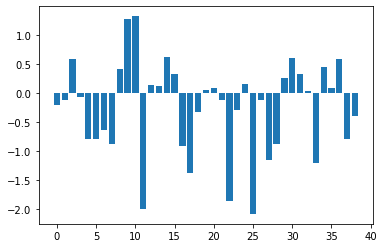

In [24]:
# get importance
importance = models[0].coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [25]:
for model, name in zip(models, model_names):
    print(name + ": {:.4f}%".format(model.score(X_test, y_test) * 100))
    y_pred_1 = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred_1))
    print(classification_report(y_test, y_pred_1))
    # model.predict_proba(X_test)

   Logistic Regression: 81.8182%
[[66 15]
 [ 3 15]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        81
           1       0.50      0.83      0.62        18

    accuracy                           0.82        99
   macro avg       0.73      0.82      0.75        99
weighted avg       0.87      0.82      0.83        99

Support Vector Machine: 83.8384%
[[80  1]
 [15  3]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91        81
           1       0.75      0.17      0.27        18

    accuracy                           0.84        99
   macro avg       0.80      0.58      0.59        99
weighted avg       0.83      0.84      0.79        99

         Decision Tree: 78.7879%
[[71 10]
 [11  7]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        81
           1       0.41      0.39      0.40        18

    accuracy              

In [26]:
list(zip(models, model_names))

[(LogisticRegression(), '   Logistic Regression'),
 (SVC(probability=True), 'Support Vector Machine'),
 (DecisionTreeClassifier(), '         Decision Tree'),
 (MLPClassifier(), '        Neural Network'),
 (RandomForestClassifier(), '         Random Forest')]

In [27]:
from sklearn.metrics import roc_curve, auc

y_pred_logistic = models[0].decision_function(X_test)


logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_logistic)
auc_logistic = auc(logistic_fpr, logistic_tpr)

auc_logistic

0.8724279835390947

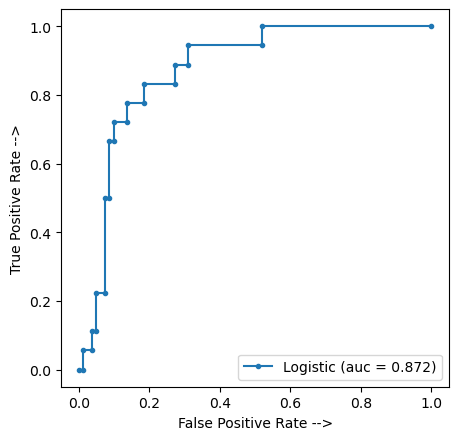

In [28]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

# Choosing best model

In [29]:
from sklearn.model_selection import GridSearchCV
#from sklearn import svm

In [30]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [1, 10, 20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto', max_iter=300),
        'params': {
            'solver': ['lbfgs', 'liblinear'],
            #'C': [1,5,10]
            'C': np.geomspace(1e-5, 1e5, num=20)
        }
    },
    'neural_network': {
        'model': MLPClassifier(max_iter=100),
        'params': {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
    }
}

In [31]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_res, y_res)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

In [32]:
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.965216,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.940432,{'n_estimators': 10}
2,logistic_regression,0.893086,"{'C': 69.51927961775606, 'solver': 'lbfgs'}"
3,neural_network,0.960340,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."


In [33]:
#print(df.iloc[3]['best_params'])

In [34]:
svc_model = SVC(C=10, kernel='rbf', gamma='auto', probability=True)
rf = RandomForestClassifier(n_estimators=10)
lr = LogisticRegression(multi_class='auto', max_iter=300, C=69.51927961775606, solver='lbfgs')
nn = MLPClassifier(max_iter=100, activation='relu', alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive', solver='adam')

In [35]:
svc_model.fit(X_res, y_res)
rf.fit(X_res, y_res)
lr.fit(X_res, y_res)
nn.fit(X_res, y_res)

C:\Users\João António Sousa\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              max_iter=100)

In [36]:
from sklearn.metrics import roc_auc_score
y_pred_proba = rf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba[:,1]))

y_pred_proba = nn.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba[:,1]))

0.8021262002743484
0.8744855967078189


In [37]:
y_pred_svc = svc_model.decision_function(X_test)
#y_pred_rf = rf.decision_function(X_test)
y_pred_lr = lr.decision_function(X_test)
#y_pred_nn = nn.decision_function(X_test)

In [38]:
svc_fpr, svc_tpr, threshold = roc_curve(y_test, y_pred_svc)
auc_svc = auc(svc_fpr, svc_tpr)

lr_fpr, lr_tpr, threshold = roc_curve(y_test, y_pred_lr)
auc_lr = auc(lr_fpr, lr_tpr)

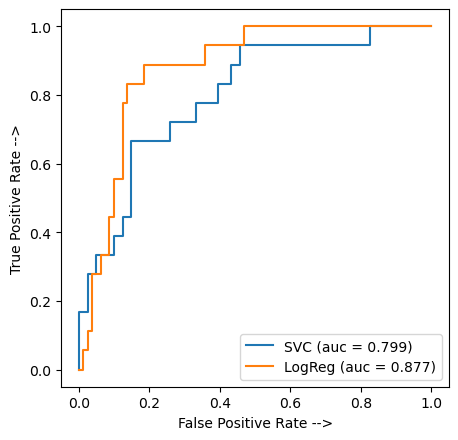

In [39]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(svc_fpr, svc_tpr, linestyle='-', label='SVC (auc = %0.3f)' % auc_svc)
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='LogReg (auc = %0.3f)' % auc_lr)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

# Logaritmic Loss

In [40]:
from sklearn.metrics import log_loss

# Logistic Regression
pred_proba_lr = lr.predict_proba(X_res)
print("Log Loss on Training is: ", log_loss(y_res, pred_proba_lr))
pred_proba_lr_t = lr.predict_proba(X_test)
print("Log Loss on Testing is: ", log_loss(y_test, pred_proba_lr_t))

# Neural Network
pred_proba_nn = nn.predict_proba(X_res)
print("Log Loss on Training is: ", log_loss(y_res, pred_proba_nn))
pred_proba_nn_t = nn.predict_proba(X_test)
print("Log Loss on Testing is: ", log_loss(y_test, pred_proba_nn_t))

# SVC
pred_proba_svc = svc_model.predict_proba(X_res)
print("Log Loss on Training is: ", log_loss(y_res, pred_proba_svc))
pred_proba_svc_t = svc_model.predict_proba(X_test)
print("Log Loss on Testing is: ", log_loss(y_test, pred_proba_svc_t))

Log Loss on Training is:  0.20574444769086478
Log Loss on Testing is:  0.7003901442170318
Log Loss on Training is:  0.02719912312111712
Log Loss on Testing is:  0.4537201648614062
Log Loss on Training is:  0.005077917618483818
Log Loss on Testing is:  0.9207964788491115


In [41]:
def preprocess_inputs_to_classify(df):
    df = df.copy()
    
    # Drop index column
    df = df.drop('Unnamed: 0', axis=1)
    
    # Create datetime columns
    for column in ['date', 'loan date', 'birthdate']:
        df[column] = pd.to_datetime(df[column])
    
    df['account_year'] = df['date'].apply(lambda x : x.year)
    df['account_month'] = df['date'].apply(lambda x : x.month)
    df['account_day'] = df['date'].apply(lambda x : x.day)
    
    df['loan_year'] = df['loan date'].apply(lambda x : x.year)
    df['loan_month'] = df['loan date'].apply(lambda x : x.month)
    df['loan_day'] = df['loan date'].apply(lambda x : x.day)
    
    df['birth_year'] = df['birthdate'].apply(lambda x : x.year)
    df['birth_month'] = df['birthdate'].apply(lambda x : x.month)
    df['birth_day'] = df['birthdate'].apply(lambda x : x.day)
    
    z  = df[['loan_id']]
    
    df = df.drop(['date', 'loan_id', 'loan date', 'birthdate'], axis=1)
    
    
    # Binary encode the Gender column
    df = binary_encode(df, 'sex', positive_value='M')
    
    # Ordinal encode the frequency column
    freq_ordering = [
        'monthly issuance',
        'weekly issuance',
        'issuance after transaction'
    ]
    df = ordinal_encode(df, 'frequency', ordering=freq_ordering)
    
    # Binary encode the card column (has or not card)
    freq_ordering = [
        'monthly issuance',
        'weekly issuance',
        'issuance after transaction'
    ]
    
    df = special_binary_encode(df, 'card type', negative_value='None')
    
    # Encode the label (loan status) column
    # label_mapping = {-1: 1, 1: 0}
    # df['loan status'] = df['loan status'].replace(label_mapping)
    
    # Split df into X and y
    y = df['loan status'].copy()
    X = df.drop('loan status', axis=1).copy()
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y, z

In [42]:
X_to_predict, y_to_predict, loan_id_col = preprocess_inputs_to_classify(to_predict)
X_to_predict.shape

(354, 39)

In [43]:
predictions = lr.predict_proba(X_to_predict) #.round(4)

In [44]:
np.bincount(lr.predict(X_to_predict))

array([277,  77], dtype=int64)

In [45]:
pred_To_Class_map = pd.DataFrame(predictions, columns=lr.classes_)
pred_To_Class_map['Id'] = loan_id_col
predictions_df = pred_To_Class_map[['Id', 1]]

In [46]:
#A,C = 0, B,D = 1

In [47]:
predictions_df = predictions_df.set_index('Id').rename(columns={1: 'Predicted'})
predictions_df

,Predicted
Id,
6173,1.476711e-10
5889,1.263458e-05
6705,1.697844e-01
5036,1.218866e-03
7115,1.119428e-04
...,...
6859,3.857927e-02
6539,1.160321e-03
5226,1.876556e-01


In [48]:
predictions_df.columns

Index(['Predicted'], dtype='object')

In [49]:
#predictions_df.to_csv('predictions_lr_mini_improve.csv', sep=',', header=True)